@Author E.Drakaki for CAMS-NCP Greece, 2024

This script:
1. masks Greece to different regions

2. calculates 24-hour mean concentrations

3. find number of dust events according to WMO guidelines 
(WMO guidelines for PM10:
24-hour average concentration 
Air quality guideline (AQG)
45-50 μg/m3
50-75 μg/m3
75-100 μg/m3
greater than 150 μg/m3

https://www.who.int/news-room/feature-stories/detail/what-are-the-who-air-quality-guidelines
World Health Organization. WHO global air quality guidelines: particulate matter (PM2. 5 and PM10), ozone, nitrogen dioxide, sulfur dioxide and carbon monoxide. World Health Organization, 2021.)


In [35]:
import numpy as np
import matplotlib.pyplot as plt
import shapely
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import packaging
import pooch
import geopandas as gpd
import pandas as pd
import rasterio as rio
import xarray as xr
import regionmask
import matplotlib.patheffects as pe
from netCDF4 import Dataset# 
import os

Open monthly file

In [ ]:

Fn='/mnt/nas2/PSD_ON_SOURCE/CAMS/CAMS_DUST/NEW_CLIMATOLOGY/REGIONAL/2020/cams.eaq.vra.ENSa.dust.l0.2020-01.nc'
#convert file to xarray dataset
ds1 = xr.open_dataset(Fn)
ds1.close()


In [ ]:
ds1

In [ ]:
ds1.dust.units

MASK GREEK PERIFEREIES

read shapefile

In [36]:
shpl ='./periphereiew.json'
greek_regions=gpd.read_file(shpl)


open a sample file

In [ ]:
Fn='./2020/cams.eaq.vra.ENSa.dust.l0.2020-01.nc'
#convert file to xarray dataset
ds1 = xr.open_dataset(Fn)
ds1.close()

create mask

In [37]:
mask  = regionmask.mask_geopandas(greek_regions, ds1.lon.values, ds1.lat.values)
#lat lon must have the same name as the xarray dataset if not rename them
# mask = mask.rename({'lon':'longitude', 'lat':'latitude'})
mask


<xarray.DataArray 'mask' (lat: 420, lon: 700)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float64 30.05 30.15 30.25 30.35 ... 71.65 71.75 71.85 71.95
  * lon      (lon) float64 -24.95 -24.85 -24.75 -24.65 ... 44.75 44.85 44.95

For Latin names, create a new column

In [72]:
greek_regions.PER2=greek_regions.PER.copy()
greek_regions.PER2[0]='EAST MACEDONIA AND THRACE'
greek_regions.PER2[1]='CENTRAL MACEDONIA'
greek_regions.PER2[2]='WEST MACEDONIA'
greek_regions.PER2[3]='EPIRUS'
greek_regions.PER2[4]='THESSALY'
greek_regions.PER2[5]='NORTH AEGEAN ISLANDS'
greek_regions.PER2[6]='SOUTH AEGEAN ISLANDS'
greek_regions.PER2[7]='STEREA ELLADA'
greek_regions.PER2[8]='WEST GREECE'
greek_regions.PER2[9]='PELOPONNESE'
greek_regions.PER2[10]='IONIAN ISLANDS'
greek_regions.PER2[11]='CRETE'
greek_regions.PER2[12]='ATTICA'

/mnt/data/elenidra/anaconda3/envs/WRF_DUST/lib/python3.7/site-packages/geopandas/geodataframe.py:182: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super(GeoDataFrame, self).__setattr__(attr, val)


Plot regions
each region has a number e.g mask==3 is Ipirus

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
mask.where(mask == 3).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='tab20', add_colorbar=False)
mask.where(mask == 9).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='tab20', add_colorbar=False)
mask.where(mask == 11).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='tab20', add_colorbar=False)
mask.where(mask == 12).plot(ax=ax, transform=ccrs.PlateCarree(), cmap='tab20', add_colorbar=False)

greek_regions.boundary.plot(ax=ax, transform=ccrs.PlateCarree(), color='black')
ax.coastlines()
ax.set_extent([20, 30, 34, 42])
plt.show()

Find the number of day with values 

WMO guidelines for PM10
24-hour average concentration 
Air quality guideline (AQG)
45-50 μg/m3
50-75 μg/m3
75-100 μg/m3
>150 μg/m3

https://www.who.int/news-room/feature-stories/detail/what-are-the-who-air-quality-guidelines
World Health Organization. WHO global air quality guidelines: particulate matter (PM2. 5 and PM10), ozone, nitrogen dioxide, sulfur dioxide and carbon monoxide. World Health Organization, 2021.

In [38]:
files = []
DIR = '/mnt/nas2/PSD_ON_SOURCE/CAMS/CAMS_DUST/NEW_CLIMATOLOGY/REGIONAL/'
years = ['2018','2019','2020','2021']
months = ['01','02','03','04','05']
ds_daily_PER={}
RGNS={}
#create a dataframe to store the results
for i,prp in enumerate(greek_regions.PER):
    print(prp)
    df = pd.DataFrame(columns=['month','year','45-50','50-75','75-100','100-150','150'])
    for year in years:
        for month in months:
            fn=DIR+year+'/cams.eaq.vra.ENSa.dust.l0.'+year+'-'+month+'.nc'
            print(fn)
            ds = xr.open_dataset(fn)
            #calculate daily mean
            ds_daily_mean = ds.sortby('time').resample(time='D').mean()
            ds.close()
            #replace ds_daily_PER
            ds_daily_PER=ds_daily_mean.where(mask==i).dust
            #if ds_daily_PER is not empty 
            if ds_daily_PER.count().values>0:
                level0=ds_daily_PER.max(dim=['lat', 'lon']).where(ds_daily_PER.max(dim=['lat', 'lon'])>45).where(ds_daily_PER.max(dim=['lat', 'lon'])<=50)
                level1=ds_daily_PER.max(dim=['lat', 'lon']).where(ds_daily_PER.max(dim=['lat', 'lon'])>50).where(ds_daily_PER.max(dim=['lat', 'lon'])<=75)
                level2=ds_daily_PER.max(dim=['lat', 'lon']).where(ds_daily_PER.max(dim=['lat', 'lon'])>75).where(ds_daily_PER.max(dim=['lat', 'lon'])<=100)
                level3=ds_daily_PER.max(dim=['lat', 'lon']).where(ds_daily_PER.max(dim=['lat', 'lon'])>100).where(ds_daily_PER.max(dim=['lat', 'lon'])<=150)
                level4=ds_daily_PER.max(dim=['lat', 'lon']).where(ds_daily_PER.max(dim=['lat', 'lon'])>150)
                
                count_45_50 =level0.count('time').values
                count_50_75 =level1.count('time').values
                count_75_100 =level2.count('time').values
                count_100_150 =level3.count('time').values
                count_150 =level4.count('time').values
            else:
                print(prp,'no data')
                count_45_50 = 0
                count_50_75 = 0
                count_75_100 = 0
                count_100_150 = 0
                count_150 = 0
                
            d={'month':month,'year':year,'45-50':count_45_50,'50-75':count_50_75,'75-100':count_75_100,'100-150':count_100_150,'150':count_150}
            df=df.append(d,ignore_index=True)
            del ds_daily_PER,count_45_50,count_50_75,count_75_100,count_100_150,count_150
    RGNS[prp]=df.copy()
    del df
            
                

Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ
/mnt/nas2/PSD_ON_SOURCE/CAMS/CAMS_DUST/NEW_CLIMATOLOGY/REGIONAL/2018/cams.eaq.vra.ENSa.dust.l0.2018-01.nc
Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ no data
/mnt/nas2/PSD_ON_SOURCE/CAMS/CAMS_DUST/NEW_CLIMATOLOGY/REGIONAL/2018/cams.eaq.vra.ENSa.dust.l0.2018-02.nc
Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ no data
/mnt/nas2/PSD_ON_SOURCE/CAMS/CAMS_DUST/NEW_CLIMATOLOGY/REGIONAL/2018/cams.eaq.vra.ENSa.dust.l0.2018-03.nc
Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ no data
/mnt/nas2/PSD_ON_SOURCE/CAMS/CAMS_DUST/NEW_CLIMATOLOGY/REGIONAL/2018/cams.eaq.vra.ENSa.dust.l0.2018-04.nc
Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ no data
/mnt/nas2/PSD_ON_SOURCE/CAMS/CAMS_DUST/NEW_CLIMATOLOGY/REGIONAL/2018/cams.eaq.vra.ENSa.dust.l0.2018-05.nc
Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ no data
/mnt/nas2/PSD_ON_SOURCE/CAMS/CAMS_DUST/NEW_CLIMATOLOGY/REGIONAL/2019/cams.eaq.vra.ENSa.dust.l0.2019-01.nc
Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ no data
/mnt/nas2/PSD_ON_SOURCE/CAMS/CAMS_DUST/NEW_CLIMATOLOGY/REGIONAL/2019/cams.eaq.

In [39]:
RGNS

{'Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ':    month  year 45-50 50-75 75-100 100-150 150
 0     01  2018     0     0      0       0   0
 1     02  2018     0     0      0       0   0
 2     03  2018     0     0      0       0   0
 3     04  2018     0     0      0       0   0
 4     05  2018     0     0      0       0   0
 5     01  2019     0     0      0       0   0
 6     02  2019     0     0      0       0   0
 7     03  2019     0     0      0       0   0
 8     04  2019     0     0      0       0   0
 9     05  2019     0     0      0       0   0
 10    01  2020     0     0      0       0   0
 11    02  2020     0     0      0       0   0
 12    03  2020     0     1      1       0   0
 13    04  2020     0     0      0       0   0
 14    05  2020     1     0      0       0   0
 15    01  2021     0     0      0       0   0
 16    02  2021     0     0      0       0   0
 17    03  2021     0     0      0       0   0
 18    04  2021     0     0      0       0   0
 19    05  2021     1  

In [40]:
RGNS.items()

dict_items([('Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ',    month  year 45-50 50-75 75-100 100-150 150
0     01  2018     0     0      0       0   0
1     02  2018     0     0      0       0   0
2     03  2018     0     0      0       0   0
3     04  2018     0     0      0       0   0
4     05  2018     0     0      0       0   0
5     01  2019     0     0      0       0   0
6     02  2019     0     0      0       0   0
7     03  2019     0     0      0       0   0
8     04  2019     0     0      0       0   0
9     05  2019     0     0      0       0   0
10    01  2020     0     0      0       0   0
11    02  2020     0     0      0       0   0
12    03  2020     0     1      1       0   0
13    04  2020     0     0      0       0   0
14    05  2020     1     0      0       0   0
15    01  2021     0     0      0       0   0
16    02  2021     0     0      0       0   0
17    03  2021     0     0      0       0   0
18    04  2021     0     0      0       0   0
19    05  2021     1     0    

In [ ]:
# RGNS
# #from dataframes remove total column
# for k,v in RGNS.items():
#     v['total']=v['25-50']+v['50-75']+v['75-100']+v['100']
#     v.drop(columns=['total'],inplace=True)
#     RGNS[k]=v.copy()
#     del v


In [41]:
#save each region to a csv file
for key in RGNS.keys():
    RGNS[key].to_csv('./'+key+'.csv')
    print(key)
    print(RGNS[key])
    print('-----------------')

Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ
   month  year 45-50 50-75 75-100 100-150 150
0     01  2018     0     0      0       0   0
1     02  2018     0     0      0       0   0
2     03  2018     0     0      0       0   0
3     04  2018     0     0      0       0   0
4     05  2018     0     0      0       0   0
5     01  2019     0     0      0       0   0
6     02  2019     0     0      0       0   0
7     03  2019     0     0      0       0   0
8     04  2019     0     0      0       0   0
9     05  2019     0     0      0       0   0
10    01  2020     0     0      0       0   0
11    02  2020     0     0      0       0   0
12    03  2020     0     1      1       0   0
13    04  2020     0     0      0       0   0
14    05  2020     1     0      0       0   0
15    01  2021     0     0      0       0   0
16    02  2021     0     0      0       0   0
17    03  2021     0     0      0       0   0
18    04  2021     0     0      0       0   0
19    05  2021     1     0      0       0   0


In [44]:
df1 = pd.DataFrame(columns=['PER','50-75','75-100','100-150','>150'])
for key in RGNS.keys():
    print(key)
    #print(RGNS[key])
    #find maximum dust days
    
    d={'PER':key,'50-75':RGNS[key]['50-75'].max(),'75-100':RGNS[key]['75-100'].max(),'100-150':RGNS[key]['100-150'].max(),'>150':RGNS[key]['150'].max()}
    df1=df1.append(d,ignore_index=True)
df1.to_csv('/mnt/nas2/PSD_ON_SOURCE/CAMS/CAMS_DUST/NEW_CLIMATOLOGY/REGIONAL/PER_max_dust_days_2018-2021.csv')
    



Π. ΑΝΑΤΟΛΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ - ΘΡΑΚΗΣ
Π. ΚΕΝΤΡΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ
Π. ΔΥΤΙΚΗΣ ΜΑΚΕΔΟΝΙΑΣ
Π. ΗΠΕΙΡΟΥ
Π. ΘΕΣΣΑΛΙΑΣ
Π. ΒΟΡΕΙΟΥ ΑΙΓΑΙΟΥ
Π. ΝΟΤΙΟΥ ΑΙΓΑΙΟΥ
Π. ΣΤΕΡΕΑΣ ΕΛΛΑΔΑΣ
Π. ΔΥΤΙΚΗΣ ΕΛΛΑΔΑΣ
Π. ΠΕΛΟΠΟΝΝΗΣΟΥ
Π. ΙΟΝΙΩΝ ΝΗΣΩΝ
Π. ΚΡΗΤΗΣ
Π. ΑΤΤΙΚΗΣ


convert type of df to plot

In [67]:
df1['PER'] = df1['PER'].astype(str)
df1['50-75'] = df1['50-75'].astype(int)
df1['75-100'] = df1['75-100'].astype(int)
df1['100-150'] = df1['100-150'].astype(int)
df1['>150'] = df1['>150'].astype(int)

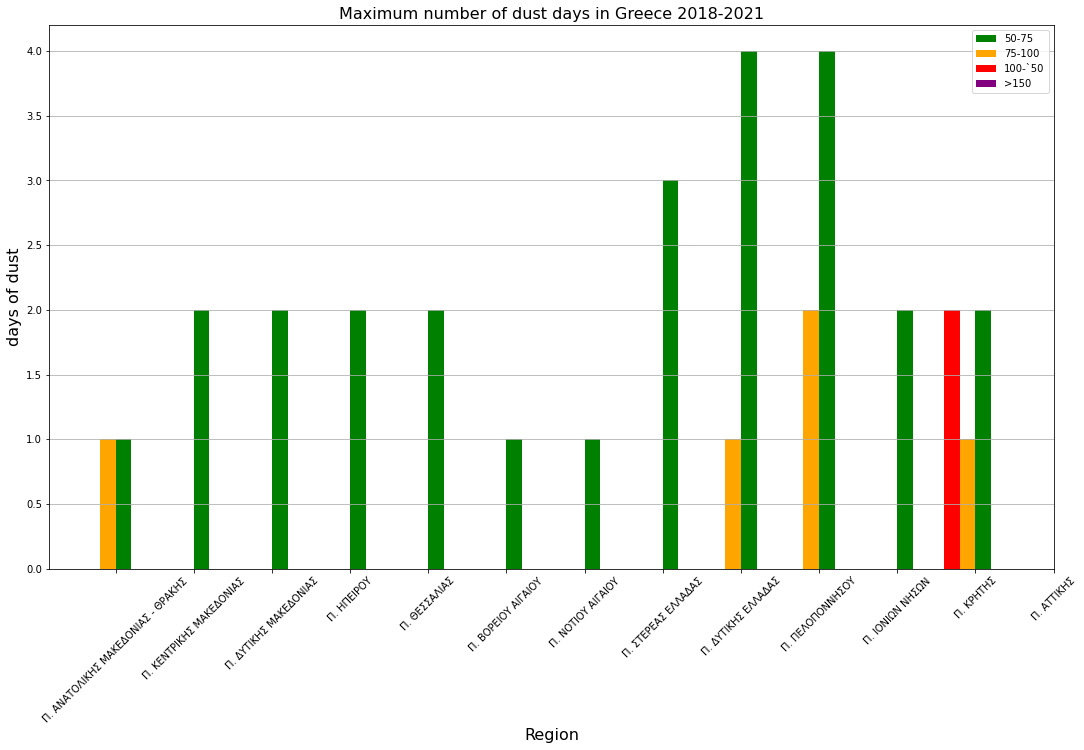

In [68]:
#df1 to barplot for each region
fig, ax = plt.subplots(figsize=(18, 10))
#stacked barplots for 50-75, 75-100, >100
df1.plot.bar(x='PER', y='50-75', ax=ax,position=0, color='green', width=0.2, label='50-75', rot=0)
df1.plot.bar(x='PER', y='75-100', ax=ax,position=1, color='orange', width=0.2, label='75-100', rot=0)
df1.plot.bar(x='PER', y='100-150', ax=ax,position=2, color='red', width=0.2, label='100-150', rot=0)
df1.plot.bar(x='PER', y='>150', ax=ax,position=3, color='purple', width=0.2, label='>150', rot=0)
ax.set_ylabel('days of dust', fontsize=16)
ax.set_xlabel('Region', fontsize=16)
#rotate xticklabels
plt.xticks(rotation=45)
plt.title('Maximum number of dust days in Greece 2018-2021', fontsize=16)
#add gridlines
ax.grid(axis='y')
#savefig
savefig='./PER_max_dust_days_2018-2021.png'
plt.savefig(savefig)